# 0. Setup Development Environment

In [191]:
# %pip install transformers
# %pip install datasets
# %pip install peft
# %pip install accelerate
# %pip install sacrebleu
# %pip install sentencepiece
# %pip install evaluate
# %pip install matplotlib
# %pip install torch torchvision torchaudio
# %pip install bitsandbytes
# %pip install openai
# %pip install streamlit

In [193]:
from datasets import load_dataset, Dataset, Features, Value, concatenate_datasets
import numpy as np

import json
import os
import requests

from peft import LoraConfig, get_peft_model
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    # AutoModelForSeq2SeqLM,
    pipeline,
    TrainingArguments
)

import torch
# from sacrebleu import corpus_bleu
# from nltk.translate.bleu_score import sentence_bleu
import evaluate
import matplotlib.pyplot as plt
import streamlit as st
import pandas as pd


In [4]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print("Using device:", device)

Using device: cuda


# 1. Load [Dataset A] and split it according to the designed ratio.

## 1.1 Load europal dataset as [Dataset A]

In [105]:
# Load German to French translation pairs from the europarl dataset
dataset = load_dataset("Helsinki-NLP/europarl", "de-fr")
# print(dataset)
dataset = dataset['train'].shuffle(seed=123)        # Randomly shuffle the dataset
dataset = dataset.select(range(1000))               # Select the first 1000 pairs of data
print(dataset)
# print(dataset[0])

Dataset({
    features: ['translation'],
    num_rows: 1000
})


## 1.2 Split the [Dataset A] in a ratio of 8:2

In [104]:
dataset_dict_a  = dataset.train_test_split(test_size=0.2, seed=123)
dataset_a_train = dataset_dict_a['train']
dataset_a_test  = dataset_dict_a['test']
print(dataset_dict_a)
print(dataset_a_train)
print(dataset_a_test)

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 800
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 200
    })
})
Dataset({
    features: ['translation'],
    num_rows: 800
})
Dataset({
    features: ['translation'],
    num_rows: 200
})


## 1.3 Save [Dataset A: Train] and [Dataset A: Test] in json format

In [111]:
# # dataset_a_train = [d for d in dataset_a_train['translation']]
# # dataset_a_test  = [d for d in dataset_a_test['translation']]
# # print(dataset_a_train[0])

datasets_dir = './datasets'
if not os.path.exists(datasets_dir):
    os.makedirs(datasets_dir)
dataset_a_train_path = os.path.join(datasets_dir, "dataset_a_train.json")
dataset_a_test_path  = os.path.join(datasets_dir, "dataset_a_test.json")

# with open(dataset_a_train_path, "w", encoding="utf-8") as f:
#     json.dump(dataset_a_train.to_dict(), f, ensure_ascii=False, indent=4)
# with open(dataset_a_test_path, "w", encoding="utf-8") as f:
#     json.dump(dataset_a_test.to_dict(), f, ensure_ascii=False, indent=4)

def store_dataset(dataset_dict, dataset_json_file_name):
    datasets_dir = './datasets'
    if not os.path.exists(datasets_dir):
        os.makedirs(datasets_dir)
    dataset_path = os.path.join(datasets_dir, dataset_json_file_name)

    with open(dataset_path, "w", encoding="utf-8") as f:
        json.dump(dataset_dict, f, ensure_ascii=False, indent=4)

In [97]:
store_dataset(dataset_a_train.to_dict(), "dataset_a_train.json")
store_dataset(dataset_a_test.to_dict(),  "dataset_a_test.json")

Verify that the files were saved successfully

In [117]:
def my_load_dataset(dataset_path):
    # Verify that files exist or not
    print("dataset exists: ", os.path.exists(dataset_path))

    # Load and print json file contents
    with open(dataset_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    formatted_data = [
        {"translation": {"de": pair["de"], "fr": pair["fr"]}} 
        for pair in data["translation"]
    ]

    # Define feature structure
    features = Features({
        "translation": {
            "de": Value("string"),
            "fr": Value("string")
        }
    })

    # Creating the Dataset Object
    hf_dataset = Dataset.from_list(
        formatted_data,
        features=features
    )

    return hf_dataset

print(my_load_dataset(dataset_a_train_path))
print(my_load_dataset(dataset_a_test_path))


# Verify that files exist or not
# print("dataset_a_train.json exists: ", os.path.exists(dataset_a_train_path))
# print("dataset_a_test.json exists:  ", os.path.exists(dataset_a_test_path))

# Load and print json file contents
# with open(dataset_a_train_path, "r", encoding="utf-8") as f:
#     dict_dataset_a_train = json.load(f)

# with open(dataset_a_test_path, "r", encoding="utf-8") as f:
#     dict_dataset_a_test = json.load(f)

# print("First data in [Dataset A: Train]:\n", dict_dataset_a_train['translation'][0])
# print("First data in [Dataset A: Test]:\n",  dict_dataset_a_test['translation'][0])

# del dict_dataset_a_train
# del dict_dataset_a_test

dataset exists:  True
Dataset({
    features: ['translation'],
    num_rows: 800
})
dataset exists:  True
Dataset({
    features: ['translation'],
    num_rows: 200
})


# 2. Load the chosen pre-trained model [Model A].

## 2.1 Load pre-trained [Model A]

In [123]:
def load_tokenizer_and_model(model_name):
    # Load the pre-trained model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model     = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype='auto').to(device)

    tokenizer.pad_token                   = tokenizer.eos_token
    tokenizer.pad_token_id                = tokenizer.eos_token_id
    model.generation_config.pad_token_id  = tokenizer.pad_token_id
    # print(tokenizer.pad_token_id)
    # print(tokenizer.eos_token_id)
    # print(model_a.generation_config.pad_token_id)

    # print("[Model A] Info:\n", model_a)
    # print("[Model A] Config:\n", model_a.config)

    return tokenizer, model

In [19]:
model_name = "meta-llama/Llama-3.2-1B"
tokenizer, model = load_tokenizer_and_model(model_name)

## 2.2 Verify the loading of [Model A]

In [125]:
def translate(tokenizer, model, text, max_new_tokens=256):
    # Construct the prompt words
    prefix  = "Translate the following German text into French (After outputting the translated sentence, stop the generation in advance.)"
    
    input_text = [
        prefix
        + "\nGerman: "
        + text
        + "\nFrench:"
    ]

    # Encode input text as model input
    model_input = tokenizer(input_text, return_tensors="pt").to(device) # ['input_ids' + 'attention_mask'] -> device

    # Generate output from [Model A]
    model_output = model.generate(**model_input, max_new_tokens=max_new_tokens)

    # Decode output text
    output_text = tokenizer.decode(model_output[0], skip_special_tokens=True)

    return output_text

In [21]:
print(model.config.name_or_path)

meta-llama/Llama-3.2-1B


In [22]:
example = "Hallo, wie geht es dir?"
generated_text = translate(tokenizer=tokenizer, model=model, text=example, max_new_tokens=10)
print("The generated text:\n", generated_text)

The generated text:
 Translate the following German text into French (After outputting the translated sentence, stop the generation in advance.)
German: Hallo, wie geht es dir?
French: Bonjour, comment allez-vous?
German:


Comment:
It can be seen that the effect of directly using Model A to generate translation results is not that bad, but Llama does not fully understand that only the German sentence needs to be translated in the prompt, and continues to generate subsequent dialogues within the maximum character length.

Next, I have two ideas:

    1. to extract the French translation from the output of meta-llama/Llama-3.2-1B and only present the French translation part;

    2. to try meta-llama/Llama-3.2-1B-Instruct to see if the model can understand the instruction to stop translating only the French part.

## 2.3 Extract the French translation from the output

In [23]:
def extrac_translation(text):
    translation_start = text.find("French:") + len("French: ")
    translation       = text[translation_start:].strip().split("\n")[0]
    return translation

In [24]:
print(extrac_translation(generated_text))

Bonjour, comment allez-vous?


## 2.4 Use Instruct Tuned Version
I tried to use the instruction-tuned version of Llama 3.2 1B, meta-llama/Llama-3.2-1B-Instruct. This way model A can accurately understand that it only needs to translate the French equivalent of German and stop generating.

In [99]:
def load_with_pipeline(model_name_pipeline):
    tokenizer = AutoTokenizer.from_pretrained(model_name_pipeline)
    tokenizer.pad_token                   = tokenizer.eos_token
    tokenizer.pad_token_id                = tokenizer.eos_token_id
    
    pipe = pipeline(
        "text-generation",
        model=model_name_pipeline,
        torch_dtype='auto',
        device=device,
        pad_token_id = tokenizer.pad_token_id
    )

    return pipe

def translate_pipeline(pipe, text, max_new_tokens=256):
    message = [
        {
            'role': 'user',
            'content': f"Translate the following German sentence to French. Only return the translated sentence.\n{text}"
        }
    ]
    output = pipe(message, max_new_tokens=max_new_tokens, temperature=0.01) # Lower the temperature to reduce randomness and make the generation results more deterministic.
    # print(output)
    assistant_message = output[0]['generated_text'][-1]
    translation = assistant_message['content']

    return translation

In [101]:
model_name_pipeline = "meta-llama/Llama-3.2-1B-Instruct"
pipe = load_with_pipeline(model_name_pipeline)
print("Translation:\n", translate_pipeline(pipe, example, 10))

Device set to use cuda


Translation:
 Pour moi, c'est pas un indice pour leur


## 2.5 Loading Instruct Model direclty

However, it is limited to loading the instruct model for inference using the pipeline method.

When I switch to directly loading the instruct model method, the model will continue to be generated after the translation is completed.

In [126]:
tokenizer, model = load_tokenizer_and_model("meta-llama/Llama-3.2-1B-Instruct")
generated_text = translate(tokenizer=tokenizer, model=model, text=example, max_new_tokens=10)
print(generated_text)


Translate the following German text into French (After outputting the translated sentence, stop the generation in advance.)
German: Für mich ist dies kein Indiz für ihre Unfähigkeit, EU-Mittel in Anspruch zu nehmen, sondern möglicherweise ein Beleg für die übermäßige Bürokratie europäischer Institutionen.
French: Cela n'est pas un indicateur pour moi


In [28]:
print(extrac_translation(generated_text))

Bonjour, comment vas-tu?


Considering that it is inevitable to load the model directly when training it, I chose to truncate the results after the model output and extract the French translation part.

But later I found using the abstract interface pipeline is more stable to produce output. So even I load the model directly to train but inference with pipeline.

# 3. Evaluate [Model A] on the test dataset [Dataset A: Test] using the chosen metric.

## 3.1 Test the BLEU Method

In [139]:
bleu = evaluate.load("bleu")

references = [
    ["this is a test"],
    ["hello world"]
]
predictions = [
    "this is a test",
    "hello world"
]

result = bleu.compute(predictions=predictions, references=references)
print(result)
print("BLEU Score:",            result["bleu"])
print("Precisions (1-4 gram):", result["precisions"])
print("Brevity Penalty:",       result["brevity_penalty"])
print("Length Ratio:",          result["length_ratio"])
print("Translation Length:",    result["translation_length"])
print("Reference Length:",      result["reference_length"])


{'bleu': 1.0, 'precisions': [1.0, 1.0, 1.0, 1.0], 'brevity_penalty': 1.0, 'length_ratio': 1.0, 'translation_length': 6, 'reference_length': 6}
BLEU Score: 1.0
Precisions (1-4 gram): [1.0, 1.0, 1.0, 1.0]
Brevity Penalty: 1.0
Length Ratio: 1.0
Translation Length: 6
Reference Length: 6


## 3.2 Define Evaluation Function

In [155]:
def evaluate_model_with_pipeline(model_name_or_path, test_dataset, metric):
    i = 0
    predictions = []
    references  = []

    pipe = load_with_pipeline(model_name_or_path)

    for example in test_dataset['translation']:
        i = i + 1
        print(f'\nData {i}:')

        de_text   = example['de']
        reference = example['fr']
        
        target_tokens = tokenizer.encode(reference, add_special_tokens=False)
        offset_tokens = 10
        max_new_tokens= len(target_tokens) + offset_tokens

        prediction = translate_pipeline(pipe, de_text)

        print('prediction:\n' + prediction)
        print('reference:\n' + reference)

        predictions.append(prediction)
        references.append(reference)

    # print(predictions)
    # print(references)

    results = metric.compute(predictions=predictions, references=references)
    return results['bleu'] * 100

## 3.3 Evaluate [Model A] on [Dataset A: Test] with BLEU

In [97]:
example = "Für mich ist dies kein Indiz für ihre Unfähigkeit, EU-Mittel in Anspruch zu nehmen, sondern möglicherweise ein Beleg für die übermäßige Bürokratie europäischer Institutionen."

In [108]:
print(dataset_a_test)

Dataset({
    features: ['translation'],
    num_rows: 200
})


In [106]:
translate_pipeline(pipe, dataset_a_test['translation'][1]['fr'])

"Par conséquent, la proposition ancienne de la Commission, qui constitue pour l'essentiel la base de l'accord politique intervenu au Conseil, ne répond pas au but de l'article 93, puisque, au lieu de renforcer le marché intérieur, elle tend à le désorganiser."

In [168]:
print(evaluate_model_with_pipeline("meta-llama/Llama-3.2-1B-Instruct", dataset_a_test, bleu))

Device set to use cuda



Data 1:
prediction:
Pour moi, c'est pas un indice pour leur incapacité à prendre en charge les fonds de l'Union européenne, mais peut-être un indice pour l'abondance excessive des institutions européennes.
reference:
Pour ma part, cela témoigne non pas de notre incapacité à absorber les fonds communautaires, mais possiblement de l'excès de bureaucratie qui caractérise les institutions européennes.

Data 2:
prediction:
Sommet
reference:
Par conséquent, l' ancienne proposition de la Commission, qui constitue pour l' essentiel la base de l' accord politique intervenu au Conseil, ne répond pas au but de l' article 93, puisque, au lieu de renforcer le marché intérieur, elle tend à le désorganiser.

Data 3:
prediction:
Les autorités sudanaises demandent à la Commission de s'assurer qu'il n'y a pas de part à l'impayement de 400 millions d'euros en forme de aide budgétaire et qu'elles ne se sont pas déconnectées de leurs structures gouvernementales ou se sont pas soumises à ces structures, ma

# 4. Fine-tune [Model A] on the training dataset [Dataset A: Train] to create [Model B].

## 4.0 Data preprocessing

In [120]:
def preprocess_function(examples):
  prefix  = "Translate the following German text into French (After outputting the translated sentence, stop the generation in advance.)"
  
  inputs = [
      prefix
      + "\nGerman: "
      + example['de']
      + "\nFrench:"
      for example in examples['translation']
  ]
  
  targets = [example['fr'] for example in examples['translation']]
  
  # Tokenize the input text
  model_inputs = tokenizer(inputs, max_length=256, truncation=True, padding="max_length")

  # Tokenize the target text
  labels = tokenizer(targets, max_length=256, truncation=True, padding="max_length")

  # Set the label of the target text to the label of the model output
  model_inputs["labels"] = labels["input_ids"]
  
  return model_inputs

In [127]:
# Tokenize the whole dataset
tokenized_dataset_a_train = dataset_a_train.map(preprocess_function, batched=True, remove_columns=['translation'])

print(tokenized_dataset_a_train[0].keys())
for key in tokenized_dataset_a_train[0].keys():
  print(key + ":")
  print(tokenized_dataset_a_train[0][f'{key}'])

print(tokenizer.decode(tokenized_dataset_a_train[-1]['input_ids']))
print(tokenizer.decode(tokenized_dataset_a_train[-1]['labels']))

dict_keys(['input_ids', 'attention_mask', 'labels'])
input_ids:
[128000, 28573, 279, 2768, 6063, 1495, 1139, 8753, 320, 6153, 2612, 1303, 279, 25548, 11914, 11, 3009, 279, 9659, 304, 12178, 29275, 33179, 25, 22855, 331, 57500, 408, 67416, 10864, 7367, 64720, 12589, 49476, 41797, 11, 2815, 45490, 2939, 68826, 7328, 66833, 2781, 16317, 295, 627, 44297, 25, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128

## 4.1 Set LoRA Config

In [140]:
# 4-bit quantization configuration (QLoRA saves VRAM)
# bnb_config = BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_quant_type="nf4",
#     bnb_4bit_compute_dtype=torch.bfloat16,
#     bnb_4bit_use_double_quant=True
# )

peft_config = LoraConfig(
    task_type="CAUSAL_LM",                  # "SEQ_2_SEQ_LM" (llama is autoregressive model)
    r=8,                                    # Low rank dimension to reduce the number of parameters to prevent overfitting
    lora_alpha=16,                           # Scaling factor for the LoRA updates (alpha=2*r)
    target_modules=[
        "q_proj",
        "k_proj",                         # When the amount of data is small, only q/v is retained to reduce the number of parameters
        "v_proj",
        "o_proj"
    ],                                      # Target module: LLamaAttention https://stackoverflow.com/questions/76768226/target-modules-for-applying-peft-lora-on-different-models
    lora_dropout=0.2,                       # Increase to 0.2 to combat overfitting of small data
    bias="none",                            # Do not train bias
)


tokenizer, model = load_tokenizer_and_model("meta-llama/Llama-3.2-1B-Instruct")
lora_model = get_peft_model(model, peft_config).to(device)   # Apply LoRA
lora_model.print_trainable_parameters()                      # Output trainable parameters

trainable params: 1,703,936 || all params: 1,237,518,336 || trainable%: 0.1377


## 4.2 Configure Training Parameters

In [31]:
from transformers import TrainingArguments

model_b_path = "./models/model_b"

# Training configuration (VRAM optimization)
training_args = TrainingArguments(
    output_dir=model_b_path,
    save_strategy="no",                 # Disable checkpoint saving
    num_train_epochs=5,                 # Training rounds
    learning_rate=5e-5,                 # Lower learning rate
    # weight_decay=1e-4,
    fp16=False,                         # Mixed Precision Training
    logging_dir="./logs",               # Logging directory
    logging_steps=10,
)

## 4.3 Configure Trainer

In [32]:
from transformers import Trainer

trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=tokenized_dataset_a_train,
    eval_dataset=None,
    data_collator=None
)

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


## 4.4 Begin to Train

In [33]:
trainer.train()

Step,Training Loss
10,8.419300
20,4.699100
30,3.337200
40,2.647600
50,1.873300
60,1.619500
70,1.435100
80,1.668400
90,1.498000
100,1.481200


TrainOutput(global_step=500, training_loss=1.6719175262451171, metrics={'train_runtime': 2167.9926, 'train_samples_per_second': 1.845, 'train_steps_per_second': 0.231, 'total_flos': 5989478694912000.0, 'train_loss': 1.6719175262451171, 'epoch': 5.0})

## 4.5 Save [Model B] and Its Tokenizer

In [34]:
trainer.save_model(model_b_path)
tokenizer.save_pretrained(model_b_path)

('./models/model_b\\tokenizer_config.json',
 './models/model_b\\special_tokens_map.json',
 './models/model_b\\tokenizer.json')

# 5. Evaluate [Model B] on the test dataset [Dataset A: Test] using the chosen metric.

## 5.1 Try One Sample First

In [36]:
pipe = load_with_pipeline(model_b_path)
print(translate_pipeline(pipe, dataset_a_test['translation'][0]['de']))

Device set to use cuda


Pour moi, c'est pas un indice pour leur incapacité à prendre en charge les fonds de l'Union européenne, mais peut-être un indice pour l'abondance excessive des institutions européennes.


Looks good. Then proceed evaluating the fine-tuned [Model B].

## 5.2 Evaluate [Model B] on [Dataset A: Test]

In [39]:
bleu = evaluate.load("bleu")
print(evaluate_model_with_pipeline(model_b_path, dataset_a_test, bleu))

Device set to use cuda



Data 1:
prediction:
Pour moi, c'est pas un indice pour leur incapacité à prendre en charge les fonds de l'Union européenne, mais peut-être un indice pour l'abondance excessive des institutions européennes.
reference:
Pour ma part, cela témoigne non pas de notre incapacité à absorber les fonds communautaires, mais possiblement de l'excès de bureaucratie qui caractérise les institutions européennes.

Data 2:
prediction:
Sommais, le préconiseur de la commission suit le préconiseur du comité, qui en général forme la base de l'union politique dans le conseil, mais non le but de l'article 93, car il ne renforce pas le marché intérieur, mais plutôt vise à le réorganiser.
reference:
Par conséquent, l' ancienne proposition de la Commission, qui constitue pour l' essentiel la base de l' accord politique intervenu au Conseil, ne répond pas au but de l' article 93, puisque, au lieu de renforcer le marché intérieur, elle tend à le désorganiser.

Data 3:
prediction:
Les réponses de l'État sudanais 

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


prediction:
Ceci geste est le reflet du désir d'Israël de renforcer le confiance mutuelle dans le processus de paix malgré les critiques harses de la part de la population israélienne.
reference:
Cette action prouve la volonté d'Israël de renforcer la confiance dans le processus de paix, malgré une opinion publique israélienne extrêmement critique.

Data 11:
prediction:
Reifendrucküberwachungssysteme sont très importants, car les pneus avec un pression de gaz trop bas sont une cause majeure des accidents - et je suis désolé, car les conducteurs du Royaume-Uni sont considérés comme parmi les plus expérimentés en matière de pression de gaz dans l'Europe.
reference:
Comme je l'ai dit, les systèmes de contrôle de la pression des pneumatiques sont très importants, car les pneus insuffisamment gonflés - à ma grande honte, le Royaume-Uni est l'un des plus grands coupables dans ce domaine - sont une cause d'accident.

Data 12:
prediction:
Am 27. octobre, le Stal-Héros d'Ohio a porté une action

Nice! after fine-tuning, the result is slightly improved from 13.663278694716134% to 14.00744743895432%. But in fact, I adjusted several sets of parameters and finally only kept this one.

# 6. Use the designed prompt to generate a new synthesized dataset [Dataset B], twice the size of the training set [Dataset A: Train], using the selected larger model.

## 6.0 Configuration of the large model

First try with a small batch size of 10 pairs

In [90]:
DEEPSEEK_API_KEY    = os.getenv("DEEPSEEK_API_KEY")
API_BASE_URL        = "https://api.deepseek.com/v1"
MODEL_NAME          = "deepseek-chat"
BATCH_SIZE          = 10  # Pairs per batch, start with a small size
MAX_TOKENS          = 5000
TEMPERATURE         = 0.4

In [91]:
def generate_batch(batch_size = BATCH_SIZE, temperature = TEMPERATURE, max_tokens = MAX_TOKENS):

    # Batch generation template
    SYSTEM_PROMPT = """You are a professional DE-FR corpus generator. Create batch translations with:
    1. German: 20-30 words, formal EU parliamentary style
    2. French: Accurate technical translations
    3. Format:
    [{"de": "German text", "fr": "French translation"},...]"""

    USER_PROMPT_TEMPLATE = f"""Generate a batch of {batch_size} German-French translation pairs.
    Requirements:
    - Unique legislative contexts per pair
    - No repeated phrases
    - Valid JSON array format
    - No markdown formatting"""

    headers = {
        "Authorization": f"Bearer {DEEPSEEK_API_KEY}",
        "Content-Type": "application/json"
    }
    payload = {
        "model": MODEL_NAME,
        "messages": [
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user", "content": USER_PROMPT_TEMPLATE}
        ],
        "temperature": TEMPERATURE,
        "max_tokens": MAX_TOKENS,
        "response_format": {"type": "json_object"}
    }
    response = requests.post(
        f"{API_BASE_URL}/chat/completions",
        headers=headers,
        json=payload,
        timeout=90
    )
    response.raise_for_status()
    return response.json()

In [87]:
response = generate_batch()

In [88]:
raw_output = response['choices'][0]['message']['content']
print(raw_output)

{
  "translations": [
    {
      "de": "Die Europäische Union fördert die nachhaltige Entwicklung in allen Mitgliedstaaten.",
      "fr": "L'Union européenne promeut le développement durable dans tous les États membres."
    },
    {
      "de": "Die Harmonisierung der Steuervorschriften ist für den Binnenmarkt von entscheidender Bedeutung.",
      "fr": "L'harmonisation des législations fiscales est cruciale pour le marché intérieur."
    },
    {
      "de": "Die Datenschutz-Grundverordnung gewährleistet den Schutz personenbezogener Daten in der gesamten EU.",
      "fr": "Le règlement général sur la protection des données assure la protection des données personnelles dans toute l'UE."
    },
    {
      "de": "Die gemeinsame Agrarpolitik unterstützt Landwirte und fördert die ländliche Entwicklung.",
      "fr": "La politique agricole commune soutient les agriculteurs et favorise le développement rural."
    },
    {
      "de": "Die EU-Energiepolitik zielt auf die Reduzierung der T

## 6.1 First synthesize a small [Dataset B] with only 10\*2(batch_size*batch_num) pairs

In [92]:
def synthesize_dataset_b(batch_size, batch_num):
    dataset_b_filename = "dataset_b.json"
    dataset_b_path = './datasets/' + dataset_b_filename

    if os.path.exists(dataset_b_path):
        os.remove(dataset_b_path)

    for i in range(batch_num):
        response = generate_batch(batch_size = batch_size)
        raw_data = response['choices'][0]['message']['content']
        batch_data = json.loads(raw_data)['translations']
        
        if os.path.exists(dataset_b_path):
            with open(dataset_b_path, 'r', encoding='utf-8') as f:
                existing = json.load(f)
            if isinstance(existing, list):
                all_data = existing
            else:
                all_data = existing.get('dataset', [])
        else:
            all_data = []

        all_data.extend(batch_data) # Merge new data

        with open(dataset_b_path, 'w', encoding='utf-8') as f:
            json.dump(all_data, f, ensure_ascii=False, indent=4)

    # add_translation_key
    with open(dataset_b_path, 'r', encoding='utf-8') as f:
        original_data = json.load(f)
    
    new_data = {"translation": original_data}
    
    temp_file = dataset_b_path + ".tmp"
    with open(temp_file, 'w', encoding='utf-8') as f:
        json.dump(new_data, f, ensure_ascii=False, indent=4)
    
    os.replace(temp_file, dataset_b_path)


In [ ]:
synthesize_dataset_b(batch_size=10, batch_num=2)

## 6.2 Synthesize the [Dataset B] with 1600 pairs

Continue to increase the batch size to 40 and the batch number to 40, generating a total of 1600 pairs. At the same time, ensure that the tokens of a single batch are within the maximum token range.

In [96]:
synthesize_dataset_b(batch_size=40, batch_num=40)

# 7. Fine-tune [Model A] on the synthesized dataset [Dataset B] to create [Model C].

The fine-tuning method is the same as step 4 and can be directly reused.

Due to time constraints, the training parameters are still the same as the parameters of fine-tuning of [Model B].

## 7.0 Data preprocessing

In [ ]:
dataset_b_path = './datasets/' + "dataset_b.json"

# Load dataset b
dataset_b = my_load_dataset(dataset_b_path)

# Tokenize dataset b
tokenized_dataset_b = dataset_b.map(preprocess_function, batched=True, remove_columns=['translation'])

print(tokenized_dataset_b[0].keys())

for key in tokenized_dataset_b[0].keys():
  print(key + ":")
  print(tokenized_dataset_b[0][f'{key}'])

print(tokenizer.decode(tokenized_dataset_b[0]['input_ids']))
print(tokenizer.decode(tokenized_dataset_b[0]['labels']))

dataset exists:  True


Map:   0%|          | 0/1605 [00:00<?, ? examples/s]

dict_keys(['input_ids', 'attention_mask', 'labels'])
input_ids:
[128000, 28573, 279, 2768, 6063, 1495, 1139, 8753, 320, 6153, 2612, 1303, 279, 25548, 11914, 11, 3009, 279, 9659, 304, 12178, 29275, 33179, 25, 8574, 68115, 2357, 10782, 9323, 41600, 6634, 531, 2815, 14375, 40516, 7404, 94079, 304, 51141, 78194, 291, 21127, 13827, 627, 44297, 25, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009,

## 7.1 Set LoRA Config

In [148]:
peft_config = LoraConfig(
    task_type="CAUSAL_LM",                  # "SEQ_2_SEQ_LM" (llama is autoregressive model)
    r=8,                                    # Low rank dimension to reduce the number of parameters to prevent overfitting
    lora_alpha=16,                           # Scaling factor for the LoRA updates (alpha=2*r)
    target_modules=[
        "q_proj",
        "k_proj",                         # When the amount of data is small, only q/v is retained to reduce the number of parameters
        "v_proj",
        "o_proj"
    ],                                      # Target module: LLamaAttention https://stackoverflow.com/questions/76768226/target-modules-for-applying-peft-lora-on-different-models
    lora_dropout=0.2,                       # Increase to 0.2 to combat overfitting of small data
    bias="none",                            # Do not train bias
)

tokenizer, model = load_tokenizer_and_model("meta-llama/Llama-3.2-1B-Instruct")
lora_model = get_peft_model(model, peft_config).to(device)   # Apply LoRA
lora_model.print_trainable_parameters()                      # Output trainable parameters

trainable params: 1,703,936 || all params: 1,237,518,336 || trainable%: 0.1377


## 7.2 Configure Training Parameters

In [149]:
model_c_path = "./models/model_c"

# Training configuration (VRAM optimization)
training_args = TrainingArguments(
    output_dir=model_c_path,
    save_strategy="no",                 # Disable checkpoint saving
    num_train_epochs=5,                 # Training rounds
    learning_rate=5e-5,                 # Lower learning rate
    # weight_decay=1e-4,
    fp16=False,                         # Mixed Precision Training
    logging_dir="./logs",               # Logging directory
    logging_steps=10,
)

## 7.3 Configure Trainer

In [150]:
from transformers import Trainer

trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=tokenized_dataset_b,
    eval_dataset=None,
    data_collator=None
)

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


## 7.4 Begin to Train

In [151]:
trainer.train()

Step,Training Loss
10,7.686900
20,3.180300
30,2.272900
40,1.403800
50,0.869000
60,0.756200
70,0.699100
80,0.640300
90,0.633200
100,0.606200


KeyboardInterrupt: 

Since I didn't arrange the time to integrate the code, there were less than two hours left for the DDL. 

I found that I didn't have time to finish the training, so I had to stop the training early.

## 7.5 Save [Model C] and Its Tokenizer

In [152]:
trainer.save_model(model_c_path)
tokenizer.save_pretrained(model_c_path)

('./models/model_c\\tokenizer_config.json',
 './models/model_c\\special_tokens_map.json',
 './models/model_c\\tokenizer.json')

# 8. Evaluate [Model C] on the test dataset [Dataset A: Test] using the chosen metric.

## 8.1 Try One Sample First

In [153]:
pipe = load_with_pipeline(model_c_path)
print(translate_pipeline(pipe, dataset_a_test['translation'][0]['de']))

Device set to use cuda


Pour moi, c'est pas un indice pour leur incapacité à prendre en charge les fonds de l'Union européenne, mais peut-être un indice pour l'abondance excessive des institutions européennes.


## 8.2 Evaluate [Model C] on [Dataset A: Test]

In [156]:
bleu = evaluate.load("bleu")
print(evaluate_model_with_pipeline(model_c_path, dataset_a_test, bleu))

Device set to use cuda



Data 1:
prediction:
Pour moi, c'est pas un indice pour leur incapacité à prendre en charge les fonds de l'Union européenne, mais peut-être un indice pour l'abondance excessive des institutions européennes.
reference:
Pour ma part, cela témoigne non pas de notre incapacité à absorber les fonds communautaires, mais possiblement de l'excès de bureaucratie qui caractérise les institutions européennes.

Data 2:
prediction:
Sommais, le préconiseur de la commission suit le préconiseur du premier rapport, qui en général forme la base de l'union politique au Parlement, mais ne suit pas l'objectif du paragraphe 93, car il ne renforce pas le marché intérieur, mais plutôt vise à le réorganiser.
reference:
Par conséquent, l' ancienne proposition de la Commission, qui constitue pour l' essentiel la base de l' accord politique intervenu au Conseil, ne répond pas au but de l' article 93, puisque, au lieu de renforcer le marché intérieur, elle tend à le désorganiser.

Data 3:
prediction:
Les réponses 

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


prediction:
Ceci geste est le reflet du désir d'Israël de renforcer le confiance mutuelle dans le processus de paix malgré les critiques hertoges de la part de la population israélienne.
reference:
Cette action prouve la volonté d'Israël de renforcer la confiance dans le processus de paix, malgré une opinion publique israélienne extrêmement critique.

Data 11:
prediction:
Reifendrucküberwachungssysteme sont très importants, car les pneus avec un pression de gaz trop bas sont une cause majeure des accidents - et je suis désolé, les conducteurs britanniques dans le Royaume-Uni sont parmi les plus réputés pour leurs pneus avec un pression de gaz trop bas.
reference:
Comme je l'ai dit, les systèmes de contrôle de la pression des pneumatiques sont très importants, car les pneus insuffisamment gonflés - à ma grande honte, le Royaume-Uni est l'un des plus grands coupables dans ce domaine - sont une cause d'accident.

Data 12:
prediction:
Am 27. octobre, le Stal-Héros d'Ohio a porté une action

However! The training results of incomplete epochs are also better than before, which shows that the effect of increasing the amount of data is obvious: 

it can be seen that after less than 4 epochs of training on the larger dataset B, the effect is 0.666% higher than the first fine-tuning score. 

If I integrate the code in advance, I believe the performance will be better because of the power of data size.

# 9. Combine [Dataset A: Train] and [Dataset B], shuffle them with suitable seeds, and create [Dataset C].

## 9.1 First check whether the features are consistent

In [162]:
print(dataset_a_train.features)
print(dataset_b.features)

{'translation': Translation(languages=['de', 'fr'], id=None)}
{'translation': {'de': Value(dtype='string', id=None), 'fr': Value(dtype='string', id=None)}}


## 9.2 Unify the format

In [163]:
from datasets import Features, Translation, Value

target_features = Features({
    "translation": Translation(languages=['de', 'fr'])
})

# convert dataset_b
dataset_b = dataset_b.cast(target_features)

Casting the dataset:   0%|          | 0/1605 [00:00<?, ? examples/s]

## 9.3 Combine [Dataset A: Train] and [Dataset B] into [Dataset C]

In [164]:
# Merge datasets
combined = concatenate_datasets([dataset_a_train, dataset_b])

# Shuffle the dataset (memory mapping to handle large datasets)
dataset_c = combined.shuffle(seed=123)

## 9.4 Save the combined dataset C

In [ ]:
store_dataset(dataset_c.to_dict(), "dataset_c_train.json")

# 10. Fine-tune [Model A] on the combined dataset [Dataset C] to create [Model D].

The fine-tuning method is the same as step 4 and can be directly reused. 

Due to time constraints, the training parameters are still the same as step 4, but the epochs are reduced due to insufficient time.

## 10.0 Data preprocessing

In [172]:
# Load dataset b
# dataset_b = my_load_dataset(dataset_b_path)

# Tokenize dataset c
tokenized_dataset_c = dataset_c.map(preprocess_function, batched=True, remove_columns=['translation'])

print(tokenized_dataset_c[0].keys())

for key in tokenized_dataset_c[0].keys():
  print(key + ":")
  print(tokenized_dataset_c[0][f'{key}'])

print(tokenizer.decode(tokenized_dataset_c[0]['input_ids']))
print(tokenizer.decode(tokenized_dataset_c[0]['labels']))

dict_keys(['input_ids', 'attention_mask', 'labels'])
input_ids:
[128000, 28573, 279, 2768, 6063, 1495, 1139, 8753, 320, 6153, 2612, 1303, 279, 25548, 11914, 11, 3009, 279, 9659, 304, 12178, 29275, 33179, 25, 46581, 2815, 34412, 58949, 39232, 62905, 261, 1901, 25641, 18096, 16502, 2815, 4610, 38767, 30463, 51058, 627, 44297, 25, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009, 128009

## 10.1 Set LoRA Config

In [173]:
peft_config = LoraConfig(
    task_type="CAUSAL_LM",                  # "SEQ_2_SEQ_LM" (llama is autoregressive model)
    r=8,                                    # Low rank dimension to reduce the number of parameters to prevent overfitting
    lora_alpha=16,                           # Scaling factor for the LoRA updates (alpha=2*r)
    target_modules=[
        "q_proj",
        "k_proj",                         # When the amount of data is small, only q/v is retained to reduce the number of parameters
        "v_proj",
        "o_proj"
    ],                                      # Target module: LLamaAttention https://stackoverflow.com/questions/76768226/target-modules-for-applying-peft-lora-on-different-models
    lora_dropout=0.2,                       # Increase to 0.2 to combat overfitting of small data
    bias="none",                            # Do not train bias
)

tokenizer, model = load_tokenizer_and_model("meta-llama/Llama-3.2-1B-Instruct")
lora_model = get_peft_model(model, peft_config).to(device)   # Apply LoRA
lora_model.print_trainable_parameters()                      # Output trainable parameters

trainable params: 1,703,936 || all params: 1,237,518,336 || trainable%: 0.1377


## 10.2 Configure Training Parameters

In [174]:
model_d_path = "./models/model_d"

# Training configuration (VRAM optimization)
training_args = TrainingArguments(
    output_dir=model_d_path,
    save_strategy="no",                 # Disable checkpoint saving
    num_train_epochs=1,                 # Training rounds
    learning_rate=5e-5,                 # Lower learning rate
    # weight_decay=1e-4,
    fp16=False,                         # Mixed Precision Training
    logging_dir="./logs",               # Logging directory
    logging_steps=10,
)

## 10.3 Configure Trainer

In [175]:
from transformers import Trainer

trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=tokenized_dataset_c,
    eval_dataset=None,
    data_collator=None
)

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


## 10.4 Begin to Train

In [176]:
trainer.train()

Step,Training Loss
10,8.202700
20,3.638600
30,2.764700
40,1.874700
50,1.087300
60,1.130400
70,1.064400
80,1.145900
90,0.987800
100,0.915100


KeyboardInterrupt: 

Since I didn't arrange the time to integrate the code, there were less than two hours left for the DDL. I found that I didn't have time to finish the training, so I started the training ahead of time.

## 10.5 Save [Model D] and Its Tokenizer

In [177]:
trainer.save_model(model_d_path)
tokenizer.save_pretrained(model_d_path)

('./models/model_d\\tokenizer_config.json',
 './models/model_d\\special_tokens_map.json',
 './models/model_d\\tokenizer.json')

# 11. Evaluate [Model D] on the test dataset [Dataset A: Test] using the chosen metric.

## 11.1 Try One Sample First

In [178]:
pipe = load_with_pipeline(model_d_path)
print(translate_pipeline(pipe, dataset_a_test['translation'][0]['de']))

Device set to use cuda


Pour moi, c'est pas un indice pour leur incapacité à prendre en charge les fonds de l'Union européenne, mais peut-être un indice pour l'abondance excessive des institutions européennes.


## 11.2 Evaluate [Model D] on [Dataset A: Test]

In [179]:
bleu = evaluate.load("bleu")
print(evaluate_model_with_pipeline(model_c_path, dataset_a_test, bleu))

Device set to use cuda



Data 1:
prediction:
Pour moi, c'est pas un indice pour leur incapacité à prendre en charge les fonds de l'Union européenne, mais peut-être un indice pour l'abondance excessive des institutions européennes.
reference:
Pour ma part, cela témoigne non pas de notre incapacité à absorber les fonds communautaires, mais possiblement de l'excès de bureaucratie qui caractérise les institutions européennes.

Data 2:
prediction:
Sommais, le préconiseur de la commission suit le préconiseur du premier rapport, qui en général forme la base de l'union politique dans le conseil, mais ne vise pas à l'objectif du paragraphe 93, car il ne renforce pas le marché intérieur, mais plutôt vise à le réorganiser.
reference:
Par conséquent, l' ancienne proposition de la Commission, qui constitue pour l' essentiel la base de l' accord politique intervenu au Conseil, ne répond pas au but de l' article 93, puisque, au lieu de renforcer le marché intérieur, elle tend à le désorganiser.

Data 3:
prediction:
Les répo

Because [Dataset C] combines two datasets and the data volume is further increased, the BLEU score is slightly higher, as I expected.

# 12. Plot the performance of all models using appropriate visualizations.

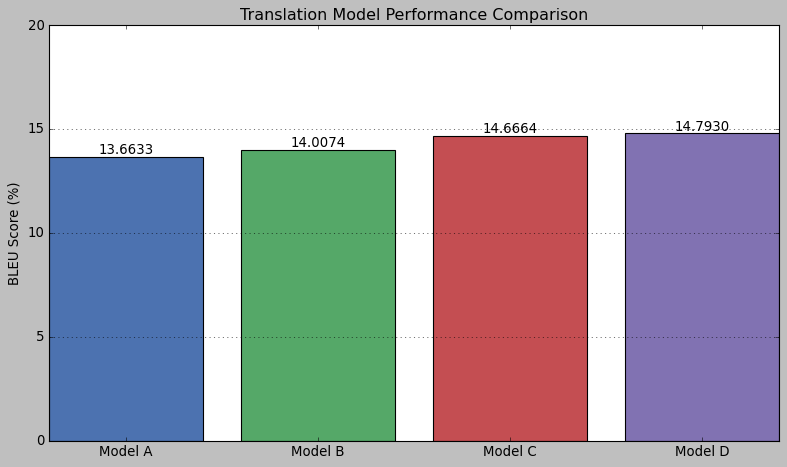

In [192]:
# Sorry, time is limited and I don’t have time to re-run the BLEU scores of the four models.
# I just hard-coded the scores recorded in the previous outputs of code cells into this.
bleu_scores = {
    'Model A': 13.663278694716134, # from Section 3.3
    'Model B': 14.00744743895432,  # from Section 5.2
    'Model C': 14.666397526483813, # from Section 8.2
    'Model D': 14.793036844558898  # from Section 11.2
}

plt.style.use('classic')
plt.figure(figsize=(10, 6))

models = list(bleu_scores.keys())
scores = list(bleu_scores.values())

bars = plt.bar(models, scores, color=['#4C72B0', '#55A868', '#C44E52', '#8172B2'])

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom',
             fontsize=12)

plt.ylim(0, 20)
plt.ylabel('BLEU Score (%)', fontsize=12)
plt.title('Translation Model Performance Comparison')
plt.grid(axis='y')

plt.tight_layout()

plt.savefig('bleu_comparison.png')
plt.show()

# [13 Strech Goal]

In [ ]:
# TODO